In [5]:
import numpy as np
import pandas as pd
import pickle
from sklearn import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange, tqdm

from utils import *

In [6]:
ENVIRONMENT = 'grand'

In [7]:
if ENVIRONMENT == 'upright':
    fail_dict = KEY_FAILURE_DICT_UPRIGHT
else:
    fail_dict = KEY_FAILURE_DICT_GRAND

# pair data collected from condition 1
incremental_X = []
incremental_y = []
incremental_info = []
for p in trange(21, 109):

    for ref_vel in range(1, 127, 1):

        for var_vel in range(ref_vel + 1, 128, 1):

            #  check whether the current key(pitch, velocity) is failed
            if p in fail_dict and (ref_vel in fail_dict[p] or var_vel in fail_dict[p]):
                continue

            ref_pitch = p
            var_pitch = p

            incremental_info.append([ref_pitch, ref_vel, var_pitch, var_vel])

            diff_D_db_flatten = get_flattened_diff_D_db(ref_pitch, ref_vel, var_pitch, var_vel, ENVIRONMENT)

            incremental_X.append(diff_D_db_flatten)
            incremental_y.append(1)

  0%|          | 0/88 [00:00<?, ?it/s]

In [8]:
# pair data collected from condition 2
pse_data = pd.read_csv(f'data/experiments/all_pse_{ENVIRONMENT}.csv')
    
pse_dict = {
    21: {32: [], 44: [], 60: [], 80: []},
    33: {32: [], 44: [], 60: [], 80: []},
    45: {32: [], 44: [], 60: [], 80: []},
    57: {32: [], 44: [], 60: [], 80: []},
    69: {32: [], 44: [], 60: [], 80: []},
    81: {32: [], 44: [], 60: [], 80: []},
    93: {32: [], 44: [], 60: [], 80: []},
    105: {32: [], 44: [], 60: [], 80: []},
    108: {32: [], 44: [], 60: [], 80: []},
}
    
pse_pitch_range = pse_data['pitch']
pse_vel_range = [32, 44, 60, 80]
for d in pse_data:
    if d == 'pitch':
        continue
    else:
        vel = int(d.split('_')[1])
        data = pse_data[d]
        for i, pse in enumerate(data):
            pse_dict[pse_pitch_range[i]][vel].append(pse)
    
mapping = {}
for p in pse_pitch_range:
    mapping[p] = [0]
    for v in pse_vel_range:

        pse_min = int(np.percentile(pse_dict[p][v], 25))
        pse_max = int(np.percentile(pse_dict[p][v], 75))

        mapping[p].append(pse_min)
        mapping[p].append(pse_max)
    if mapping[p][-1] != 127:
        mapping[p].append(127)

experimental_X = []
experimental_y = []
experimental_info = []

for ref_pitch_idx, ref_pitch in enumerate(tqdm(pse_pitch_range)):

    for ref_vel in range(1, 128):

        category = 0
        for v in mapping[ref_pitch]:
            if ref_vel > v:
                category += 1
            else:
                category -= 1
                break

        for var_pitch in pse_pitch_range[ref_pitch_idx + 1:]:

            for var_vel in range(1, 128, 1):

                #  check whether the current key(pitch, velocity) is failed
                if var_pitch in fail_dict and var_vel in fail_dict[var_pitch]:
                    continue

                if category > 0 and var_vel < mapping[var_pitch][category - 1]:
                    experimental_y.append(0)
                elif var_vel > mapping[var_pitch][category + 1]:
                    experimental_y.append(1)
                else:
                    continue

                diff_D_db_flatten = get_flattened_diff_D_db(ref_pitch, ref_vel, var_pitch, var_vel, ENVIRONMENT)

                experimental_info.append([ref_pitch, ref_vel, var_pitch, var_vel])

                experimental_X.append(diff_D_db_flatten)

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
incremental_train_X, incremental_test_X, \
incremental_train_y, incremental_test_y = train_test_split(incremental_X, incremental_y, test_size=0.20,
                                                                random_state=520)
incremental_train_info, incremental_test_info = train_test_split(incremental_info, test_size=0.20, random_state=520)

experimental_train_X, experimental_test_X, \
experimental_train_y, experimental_test_y = train_test_split(experimental_X, experimental_y, test_size=0.20, random_state=520)
experimental_train_info, experimental_test_info = train_test_split(experimental_info, test_size=0.20, random_state=520)

train_X = np.concatenate((experimental_train_X, incremental_train_X), axis=0)
train_y = np.concatenate((experimental_train_y, incremental_train_y), axis=0)

test_X = np.concatenate((experimental_test_X, incremental_test_X), axis=0)
test_y = np.concatenate((experimental_test_y, incremental_test_y), axis=0)


In [10]:
model = LogisticRegression(
    max_iter=1000000,
    verbose=1,
    n_jobs=-1,
    fit_intercept=False,
).fit(train_X, train_y)

# save
with open(f'model/model_{ENVIRONMENT}.pkl', 'wb') as f:
    pickle.dump(model, f)

train_acc = metrics.accuracy_score(incremental_test_y, model.predict(incremental_test_X))
test_acc = metrics.accuracy_score(experimental_test_y, model.predict(experimental_test_X))

print(f"The train accuracy is:", train_acc)
print(f"The test accuracy is:", train_acc)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished


The train accuracy is: 0.9520171692119644
The test accuracy is: 0.9520171692119644


In [11]:
generate_loudness_matrix(ENVIRONMENT, model)

e:\CityU\PerfTransform\ISMIR2022\ModelingPerceptualLoudnessOfPianoTone\utils.py:246: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((i-21.5, v[0]-1), 1, v[1]-v[0]+1, fill=True, color='white', edgecolor='white', lw=2, linestyle='--', zorder=1, alpha=0.7))


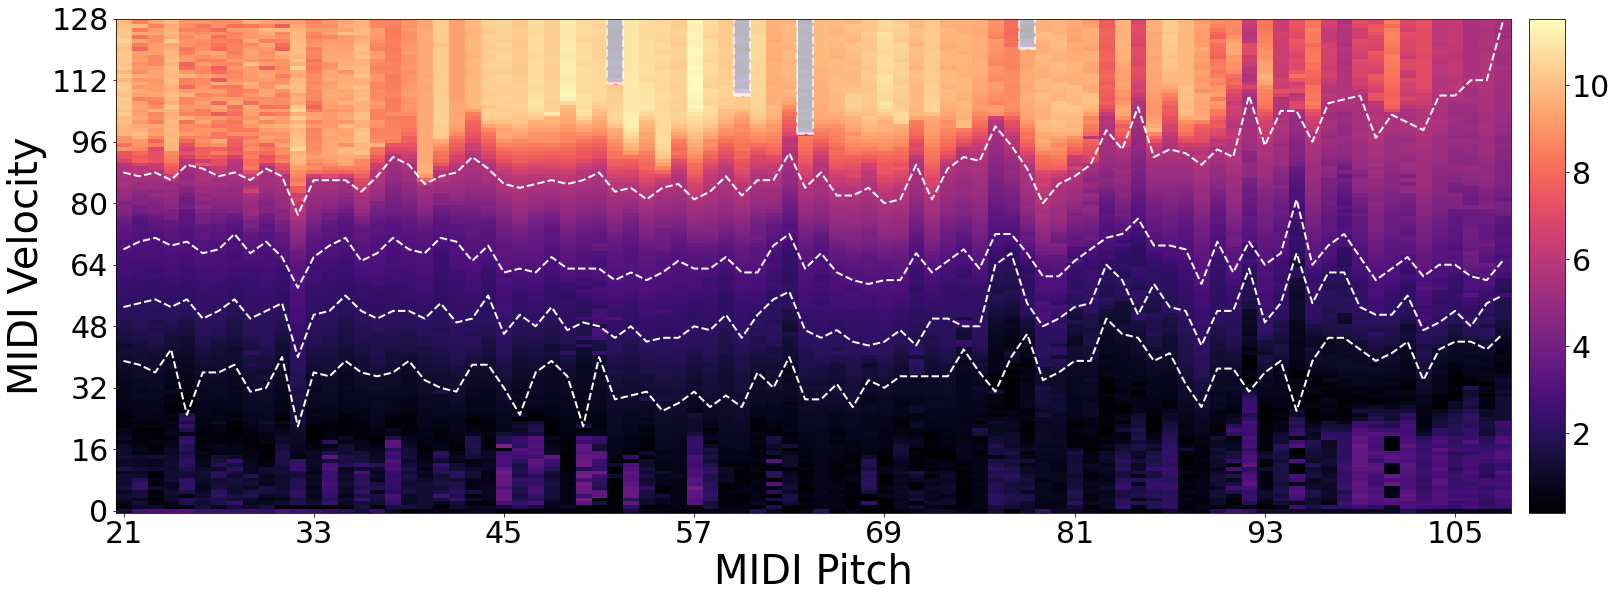

In [12]:
plot_heatmap('parametric', ENVIRONMENT)